In [1]:
from typing import List
import numpy as np


def read_hands(file: str):
    poses: List[np.ndarray] = []
    pose_size = 20 * 3  # number of floats
    with open(file, "rb") as f:
        data = f.read()
        total_floats = len(data) // 4  # float32 = 4 bytes
        if total_floats % pose_size != 0:
            raise ValueError("File size is not a multiple of single pose size")
        array = np.frombuffer(data, dtype=np.float32)
        for i in range(0, total_floats, pose_size):
            pose = array[i : i + pose_size].reshape((20, 3))
            poses.append(pose)
    return np.stack(poses, axis=0)

In [ ]:
import torch


def rot(
    v: torch.Tensor,
    p: torch.Tensor,
    alpha: torch.Tensor,
    beta: torch.Tensor,
):
    """
    Batched rotation function.

    v, p: (B, 3) tensors representing vector and the first axis of rotation
    alpha, beta: (B,) tensors representing angles to use for rotation
    """

    v = torch.nn.functional.normalize(v, dim=-1)
    p = torch.nn.functional.normalize(p, dim=-1)

    sinA = torch.sin(alpha).unsqueeze(-1)  # (B, 1)
    cosA = torch.cos(alpha).unsqueeze(-1)  # (B, 1)
    sinB = torch.sin(beta).unsqueeze(-1)  # (B, 1)
    cosB = torch.cos(beta).unsqueeze(-1)  # (B, 1)

    q = torch.cross(v, p, dim=1)  # (B, 3)

    p_hat = p.mul(cosB).sub(v.mul(sinB))
    v_hat = q.mul(sinA).add(v.mul(cosA.mul(cosB))).add(p.mul(cosA.mul(sinB)))

    return v_hat, p_hat


_P = [0, 0, 1]


def hand_landmarks_by_angles(
    angles: torch.Tensor,
    morphology: torch.Tensor,
):
    """
    angles: (B, 20)
    morphology: (5, 7) - not batched
    Returns: (B, 20, 3)
    """

    B = angles.shape[0]
    ps = []

    landmarks = torch.zeros(B, 21, 3, dtype=angles.dtype, device=angles.device)
    angles = angles.unflatten(dim=-1, sizes=(5, 4))

    # Write morphological const points
    # landmarks[:, 0, :] is already zero
    for i in range(0, 5):
        landmarks[:, 4 * i + 1, :] = morphology[i, 3:6]

    P = torch.tensor(_P, dtype=angles.dtype, device=angles.device).expand(B, 3)
    ps.append(P)

    for finger_index, (morph, local_angles) in enumerate(
        zip(morphology, angles.transpose(0, 1))
    ):
        base_idx = finger_index * 4 + 1
        bone_lengths = morph[0:3]
        joint = morph[3:6].expand(B, 3).clone()
        gamma = morph[6]

        a0, b0, a2, a3 = local_angles.unbind(dim=-1)
        chain_angles = torch.stack(
            [
                torch.stack([a0, b0], dim=-1),
                torch.stack([a2, torch.zeros_like(a2)], dim=-1),
                torch.stack([a3, torch.zeros_like(a3)], dim=-1),
            ],
            dim=1,
        )  # (B, 3, 2)

        v = torch.nn.functional.normalize(joint, dim=-1)

        # Get p perpendicular to v
        p_proj = v.mul(torch.sum(v.mul(P), dim=-1, keepdim=True))  # (B, 3)
        p = P.sub(p_proj)
        p = torch.nn.functional.normalize(p, dim=-1)

        # Rotate p around v according to parameter gamma
        sinG, cosG = torch.sin(gamma), torch.cos(gamma)
        p = p.mul(cosG).add(torch.cross(p, v, dim=-1).mul(sinG))

        if finger_index != 0:
            ps.append(p)

        # Iterate over the chain and write the 3d points
        for j in range(3):
            l = bone_lengths[j]
            alpha, beta = chain_angles[:, j, 0], chain_angles[:, j, 1]
            v, p = rot(v, p, alpha, beta)
            joint = joint.add(v.mul(l))
            landmarks[:, base_idx + j + 1, :] = joint
            ps.append(p)

    return (
        torch.cat([landmarks[:, :1, :], landmarks[:, 2:, :]], dim=1),  # cut thumb base
        torch.stack(ps, dim=1),
    )

In [36]:
import torch

E = 1e-7


def irot_full1(
    v: torch.Tensor,
    p: torch.Tensor,
    v_hat: torch.Tensor,
    v_hat_hat: torch.Tensor,
    eps: float = 0.2,  # Tolerance for "cosA == 0"
):
    """
    Batched inverse rotation function.

    v, p, v_hat: (B, 3) tensors
    Returns: alpha (B,), beta (B,), v_hat (B, 3), p_hat (B, 3)
    """

    v = torch.nn.functional.normalize(v, dim=-1)
    p = torch.nn.functional.normalize(p, dim=-1)

    q = torch.cross(v, p, dim=-1)

    dot_v = v_hat.mul(v).sum(dim=-1)  # cosB*cosA
    dot_p = v_hat.mul(p).sum(dim=-1)  # sinB*cosA
    dot_q = v_hat.mul(q).sum(dim=-1).clamp(min=-1 + E, max=1 - E)  # sinA

    alpha = torch.asin(dot_q)

    cosA = torch.ones_like(dot_q).sub(dot_q.square()).clamp(min=0).sqrt()

    beta = torch.where(
        cosA.abs().lt(eps),
        torch.zeros_like(cosA),
        torch.atan2(dot_p.div(cosA), dot_v.div(cosA)),
    )

    p_hat = p.mul(beta.cos().unsqueeze(-1)).sub(v.mul(beta.sin().unsqueeze(-1)))

    return alpha, beta, v_hat, p_hat


def irot_full2(
    v: torch.Tensor,
    p: torch.Tensor,
    v_hat: torch.Tensor,
    v_hat_hat: torch.Tensor,
    eps: float = 0.8,
):
    """
    Batched inverse rotation function.

    v, p, v_hat, v_hat_hat: (B, 3) tensors
    Returns: alpha (B,), beta (B,), v_hat (B, 3), p_hat (B, 3)
    """

    v = torch.nn.functional.normalize(v, dim=-1)
    p = torch.nn.functional.normalize(p, dim=-1)

    q = torch.cross(v, p, dim=-1)

    p_hat = torch.cross(v_hat, v_hat_hat, dim=-1)
    p_hat = torch.where(
        p_hat.norm(dim=-1).lt(eps).unsqueeze(-1),
        p,
        torch.nn.functional.normalize(p_hat, dim=-1),
    )

    cosB = p_hat.mul(p).sum(dim=-1).clamp(min=-1 + E, max=1 - E)
    sinB = p_hat.mul(v).neg().sum(dim=-1).clamp(min=-1 + E, max=1 - E)

    sinA = v_hat.mul(q).sum(dim=-1).clamp(min=-1 + E, max=1 - E)
    cosA = torch.ones_like(sinA).sub(sinA.square()).clamp(min=0).sqrt()
    v_hat_update = (
        q.mul(sinA.unsqueeze(-1))
        .add(v.mul((cosA.mul(cosB)).unsqueeze(-1)))
        .add(p.mul((cosA.mul(sinB)).unsqueeze(-1)))
    )

    beta = torch.atan2(sinB, cosB)
    alpha = torch.asin(sinA)

    return alpha, beta, v_hat_update, p_hat


def irot_full_merged(
    v: torch.Tensor,
    p: torch.Tensor,
    v_hat: torch.Tensor,
    v_hat_hat: torch.Tensor,
    eps: float = 0.8,
    eps_fallback: float = 0.2,
):
    """
    Batched inverse rotation function with improved fallback.

    v, p, v_hat, v_hat_hat: (B, 3) tensors
    Returns: alpha (B,), beta (B,), v_hat (B, 3), p_hat (B, 3)
    """

    v = torch.nn.functional.normalize(v, dim=-1)
    p = torch.nn.functional.normalize(p, dim=-1)
    q = torch.cross(v, p, dim=-1)

    # Attempt primary p_hat from cross product of v_hat and v_hat_hat
    p_hat_candidate = torch.cross(v_hat, v_hat_hat, dim=-1)
    low_norm_mask = p_hat_candidate.norm(dim=-1).lt(eps).unsqueeze(-1)

    # Fallback p_hat using irot_full1 logic
    dot_v = v_hat.mul(v).sum(dim=-1)
    dot_p = v_hat.mul(p).sum(dim=-1)
    sinA = v_hat.mul(q).sum(dim=-1).clamp(min=-1 + E, max=1 - E)

    cosA = torch.ones_like(sinA).sub(sinA.square()).clamp(min=0).sqrt()
    beta_fallback = torch.where(
        cosA.abs().lt(eps_fallback),
        torch.zeros_like(cosA),
        torch.atan2(dot_p.div(cosA), dot_v.div(cosA)),
    )
    p_hat_fallback = p.mul(beta_fallback.cos().unsqueeze(-1)).sub(
        v.mul(beta_fallback.sin().unsqueeze(-1))
    )

    # Combine: use fallback p_hat only where primary one is invalid
    p_hat = torch.where(
        low_norm_mask,
        p_hat_fallback,
        torch.nn.functional.normalize(p_hat_candidate, dim=-1),
    )

    # Continue as in irot_full
    cosB = p_hat.mul(p).sum(dim=-1)
    sinB = p_hat.mul(v).neg().sum(dim=-1)

    v_hat_update = (
        q.mul(sinA.unsqueeze(-1))
        .add(v.mul((cosA * cosB).unsqueeze(-1)))
        .add(p.mul((cosA * sinB).unsqueeze(-1)))
    )

    beta = torch.atan2(sinB, cosB)
    alpha = torch.asin(sinA)

    return alpha, beta, v_hat_update, p_hat


def irot_alpha(
    v: torch.Tensor,
    p: torch.Tensor,
    v_hat: torch.Tensor,
):
    """
    Batched inverse rotation function.

    v, p, v_hat: (B, 3) tensors
    Returns: alpha (B,), beta (B,), v_hat (B, 3), p_hat (B, 3)
    """

    v = torch.nn.functional.normalize(v, dim=-1)
    p = torch.nn.functional.normalize(p, dim=-1)

    q = torch.cross(v, p, dim=-1)

    cosA = v_hat.mul(v).sum(dim=-1).clamp(min=-1 + E, max=1 - E)
    alpha = v_hat.mul(q).sum(dim=-1).sign().mul(torch.arccos(cosA))
    beta = torch.zeros_like(cosA)
    p_hat = p

    return alpha, beta, v_hat, p_hat


def inverse_hand_angles_by_landmarks(
    landmarks: torch.Tensor,
    morphology: torch.Tensor,
):
    """
    landmarks: (B, 20, 3) - known hand landmarks in 3D space
    morphology: (5, 7) - hand morphology (not batched)

    Returns:
    angles: (B, 20) - recovered joint angles
    """

    B = landmarks.shape[0]
    ps = []

    angles = torch.zeros(B, 5, 4, dtype=landmarks.dtype, device=landmarks.device)

    # NOTE: assuming 0, 4, 8, 12, 16 landmarks are existing in the morphology
    # 20 landmarks -> 21 landmarks, restoring thumb base from the morphology
    #   so that now assuming 0, 1, 5, 9, 13, 17 are existing in the morphology
    thumb_base = morphology[0][3:6]

    landmarks = torch.cat(
        [
            landmarks[:, :1, :],
            thumb_base.expand(B, 1, 3),  # Repeat thumb_base across batch
            landmarks[:, 1:, :],
        ],
        dim=1,
    )

    P = torch.tensor(_P, dtype=angles.dtype, device=angles.device).expand(B, 3)
    ps.append(P)

    for i, morph in enumerate(morphology):
        base_idx = i * 4 + 1
        # joint = morph[3:6].expand(B, 3).clone()
        joint = landmarks[:, base_idx].sub(landmarks[:, 0])
        gamma = morph[6]

        v = torch.nn.functional.normalize(joint, dim=-1)

        # Get p perpendicular to v
        p_proj = v.mul(torch.sum(v.mul(P), dim=-1, keepdim=True))  # (B, 3)
        p = P.sub(p_proj)
        p = torch.nn.functional.normalize(p, dim=-1)

        # Rotate p around v according to parameter gamma
        sinG, cosG = torch.sin(gamma), torch.cos(gamma)
        p = p.mul(cosG).add(torch.cross(p, v, dim=-1).mul(sinG))

        if i != 0:
            ps.append(p)

        target = torch.nn.functional.normalize(
            landmarks[:, base_idx + 1].sub(landmarks[:, base_idx]), dim=-1
        )
        target2 = torch.nn.functional.normalize(
            landmarks[:, base_idx + 2].sub(landmarks[:, base_idx + 1]),
            dim=-1,
        )
        alpha, beta, v, p = irot_full_merged(v, p, target, target2)
        angles[:, i, 0] = alpha
        angles[:, i, 1] = beta
        ps.append(p)

        for j in range(1, 3):
            target = torch.nn.functional.normalize(
                landmarks[:, base_idx + j + 1].sub(landmarks[:, base_idx + j]), dim=-1
            )

            alpha, beta, v, p = irot_alpha(v, p, target)

            angles[:, i, j + 1] = alpha

            ps.append(p)

    return angles.flatten(start_dim=1), torch.stack(ps, dim=1)

In [ ]:
rec = read_hands("../dataset.rec")
y = torch.tensor(rec, dtype=torch.float32).contiguous().to("cuda")

100%|██████████| 2000/2000 [00:55<00:00, 36.03it/s]


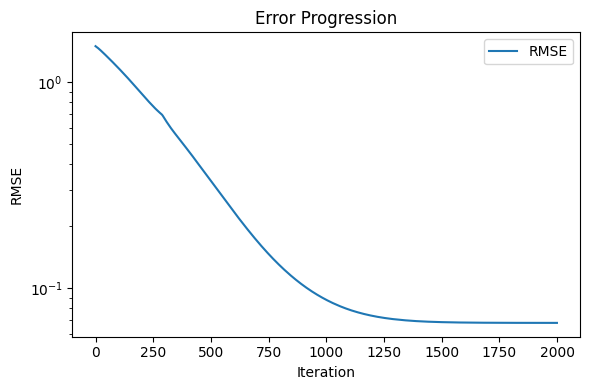

Final err: 0.06800341606140137


tensor([[ 0.5556,  0.3889,  0.2778, -0.1740,  0.2368,  0.0346,  1.7411],
        [ 0.4444,  0.2778,  0.2222, -0.0052,  0.9666,  0.2214, -0.0898],
        [ 0.5556,  0.3333,  0.2222, -0.0040,  0.9956, -0.0154, -0.0892],
        [ 0.5556,  0.3333,  0.2222, -0.0545,  0.9141, -0.2140, -0.1419],
        [ 0.4444,  0.2778,  0.2222, -0.1366,  0.7774, -0.3884, -0.1827]],
       device='cuda:0', grad_fn=<CatBackward0>)

In [37]:
from matplotlib import pyplot as plt
from tqdm import tqdm


@torch.compile(backend="cudagraphs")
def loss_fn(y: torch.Tensor, bone_lengths: torch.Tensor, morphology_base: torch.Tensor):
    morphology = torch.cat((bone_lengths, morphology_base), dim=1)
    y_hat = hand_landmarks_by_angles(
        inverse_hand_angles_by_landmarks(y, morphology)[0], morphology
    )[0]
    return y_hat.sub(y).square().sum(dim=-1).mean()


def learn_morphology(y: torch.Tensor):
    # somewhy initalizing better conditions does not help
    bone_lengths = torch.tensor(
        [
            (5.0, 3.5, 2.5),  # Thumb
            (4.0, 2.5, 2.0),  # Index
            (5.0, 3.0, 2.0),  # Middle
            (5.0, 3.0, 2.0),  # Ring
            (4.0, 2.5, 2.0),  # Pinky
        ],
        device=y.device,
        dtype=y.dtype,
        requires_grad=False,
    )
    bone_lengths = bone_lengths / 9.0  # make central bone relative sizes
    morphology_base = torch.rand(
        5, 4, device=y.device, dtype=y.dtype, requires_grad=True
    )

    # morphology = torch.rand(5, 7, device=y.device, dtype=y.dtype, requires_grad=True)

    optimizer = torch.optim.NAdam([morphology_base])
    scheduler = torch.optim.lr_scheduler.LinearLR(
        optimizer,
        start_factor=1.0,
        end_factor=0.001,
        total_iters=10000,
    )

    err_history = []
    lr_history = []

    for _ in tqdm(range(2000)):
        optimizer.zero_grad()
        loss = loss_fn(y, bone_lengths, morphology_base)
        loss.backward()

        optimizer.step()
        if scheduler:
            scheduler.step()

        err_history.append(loss.sqrt().item())
        lr_history.append(optimizer.param_groups[0]["lr"])

    return err_history, torch.cat((bone_lengths, morphology_base), dim=1)


err_history, morphology = learn_morphology(y)

# Plot error progression
plt.figure(figsize=(6, 4))
plt.plot(err_history, label="RMSE")
plt.yscale("log")
plt.xlabel("Iteration")
plt.ylabel("RMSE")
plt.title(f"Error Progression")
plt.legend()
plt.tight_layout()
plt.show()

print("Final err:", err_history[-1])
morphology

In [38]:
import torch
import numpy as np
import plotly.graph_objs as go


def plot_3d_hands(
    landmarks_sequence: torch.Tensor | np.ndarray,
    ps: torch.Tensor | np.ndarray | None = None,
    ps2: torch.Tensor | np.ndarray | None = None,
):
    if isinstance(landmarks_sequence, torch.Tensor):
        landmarks_sequence = landmarks_sequence.detach().cpu().numpy()

    if ps is not None and isinstance(ps, torch.Tensor):
        ps = ps.detach().cpu().numpy()
    if ps2 is not None and isinstance(ps2, torch.Tensor):
        ps2 = ps2.detach().cpu().numpy()

    n_frames = landmarks_sequence.shape[0]
    n_pts = landmarks_sequence.shape[1]
    labels = [str(i) for i in range(n_pts)]

    fig = go.Figure()

    # Add traces for the first frame
    fig.add_trace(
        go.Scatter3d(
            x=landmarks_sequence[0, :, 0],
            y=landmarks_sequence[0, :, 1],
            z=landmarks_sequence[0, :, 2],
            mode="markers+text",
            marker=dict(size=4, color="blue"),
            text=labels,
            textposition="top center",
            textfont=dict(size=8, color="black"),
            name="Landmarks",
        )
    )

    connections = [
        (0, 1),
        (1, 2),
        (2, 3),  # Thumb
        (0, 4),
        (4, 5),
        (5, 6),
        (6, 7),  # Index
        (0, 8),
        (8, 9),
        (9, 10),
        (10, 11),  # Middle
        (0, 12),
        (12, 13),
        (13, 14),
        (14, 15),  # Ring
        (0, 16),
        (16, 17),
        (17, 18),
        (18, 19),  # Pinky
        # Palm
        (1, 4),
        (4, 8),
        (8, 12),
        (12, 16),
    ]

    # Add traces for connections for the first frame
    for i, j in connections:
        fig.add_trace(
            go.Scatter3d(
                x=[landmarks_sequence[0, i, 0], landmarks_sequence[0, j, 0]],
                y=[landmarks_sequence[0, i, 1], landmarks_sequence[0, j, 1]],
                z=[landmarks_sequence[0, i, 2], landmarks_sequence[0, j, 2]],
                mode="lines",
                line=dict(color="black", width=2),
                showlegend=False,
            )
        )

    def add_beams(landmarks, vectors, color):
        for i in range(n_pts):
            start = landmarks[i]
            end = start + vectors[i] * 0.1
            fig.add_trace(
                go.Scatter3d(
                    x=[start[0], end[0]],
                    y=[start[1], end[1]],
                    z=[start[2], end[2]],
                    mode="lines",
                    line=dict(color=color, width=2),
                    showlegend=False,
                )
            )

    # Add ps (red) and ps2 (green) beams if provided for first frame
    if ps is not None:
        add_beams(landmarks_sequence[0], ps[0], "red")
    if ps2 is not None:
        add_beams(landmarks_sequence[0], ps2[0], "green")

    # Create frames for the animation
    frames = []
    for k in range(n_frames):
        frame_data = [
            go.Scatter3d(
                x=landmarks_sequence[k, :, 0],
                y=landmarks_sequence[k, :, 1],
                z=landmarks_sequence[k, :, 2],
                mode="markers+text",
                marker=dict(size=4, color="blue"),
                text=labels,
                textposition="top center",
                textfont=dict(size=8, color="black"),
                name="Landmarks",
            )
        ] + [
            go.Scatter3d(
                x=[landmarks_sequence[k, i, 0], landmarks_sequence[k, j, 0]],
                y=[landmarks_sequence[k, i, 1], landmarks_sequence[k, j, 1]],
                z=[landmarks_sequence[k, i, 2], landmarks_sequence[k, j, 2]],
                mode="lines",
                line=dict(color="black", width=2),
                showlegend=False,
            )
            for i, j in connections
        ]

        if ps is not None:
            for i in range(n_pts):
                start = landmarks_sequence[k, i]
                end = start + ps[k, i] * 0.1
                frame_data.append(
                    go.Scatter3d(
                        x=[start[0], end[0]],
                        y=[start[1], end[1]],
                        z=[start[2], end[2]],
                        mode="lines",
                        line=dict(color="red", width=2),
                        showlegend=False,
                    )
                )

        if ps2 is not None:
            for i in range(n_pts):
                start = landmarks_sequence[k, i]
                end = start + ps2[k, i] * 0.1
                frame_data.append(
                    go.Scatter3d(
                        x=[start[0], end[0]],
                        y=[start[1], end[1]],
                        z=[start[2], end[2]],
                        mode="lines",
                        line=dict(color="green", width=2),
                        showlegend=False,
                    )
                )

        frames.append(go.Frame(data=frame_data, name=str(k)))

    fig.frames = frames

    # Add slider and play/pause button
    sliders = [
        {
            "pad": {"b": 10, "t": 10},
            "len": 0.9,
            "x": 0.1,
            "xanchor": "left",
            "y": 0,
            "yanchor": "top",
            "steps": [
                {
                    "args": [
                        [f.name],
                        {
                            "frame": {"duration": 33.33, "redraw": True},
                            "mode": "immediate",
                            "transition": {"duration": 0},
                        },
                    ],
                    "label": str(k),
                    "method": "animate",
                }
                for k, f in enumerate(frames)
            ],
        }
    ]

    fig.update_layout(
        updatemenus=[
            {
                "buttons": [
                    {
                        "args": [
                            None,
                            {
                                "frame": {"duration": 33.33, "redraw": True},
                                "fromcurrent": True,
                                "transition": {"duration": 0},
                            },
                        ],
                        "label": "Play",
                        "method": "animate",
                    },
                    {
                        "args": [
                            [None],
                            {
                                "frame": {"duration": 0, "redraw": True},
                                "mode": "immediate",
                                "transition": {"duration": 0},
                            },
                        ],
                        "label": "Pause",
                        "method": "animate",
                    },
                ],
                "direction": "left",
                "pad": {"r": 10, "t": 30},
                "showactive": False,
                "type": "buttons",
                "x": 0.1,
                "xanchor": "right",
                "y": 0,
                "yanchor": "top",
            }
        ],
        sliders=sliders,
        scene=dict(
            xaxis=dict(
                range=[2, -2],
                title="X",
            ),
            yaxis=dict(
                range=[-1, 3],
                title="Y",
            ),
            zaxis=dict(
                range=[-2, 2],
                title="Z",
            ),
            camera=dict(eye=dict(x=0.2, y=0.2, z=0.2)),
        ),
        scene_aspectmode="cube",
        title="3D Hand Pose with Point Labels",
        margin=dict(l=0, r=0, b=0, t=30),
        height=400,
    )

    fig.show()


s, e = 200, 300
angles, ps = inverse_hand_angles_by_landmarks(y[s:e], morphology)
y_hat, ps2 = hand_landmarks_by_angles(angles, morphology)

plot_3d_hands(y[s:e], ps)
plot_3d_hands(y_hat, ps, ps2)

In [7]:
import torch


def plot_tweakable_hand(
    initial_angles: torch.Tensor, tweak_i: int, morphology: torch.Tensor
):
    frames: List[torch.Tensor] = []
    a = initial_angles[tweak_i].clone()
    for _ in range(100):
        angles = initial_angles.clone()
        angles[tweak_i] = a
        frames.append(angles)
        a += 2 * torch.pi / 100

    return plot_3d_hands(*hand_landmarks_by_angles(torch.stack(frames), morphology))


angles = inverse_hand_angles_by_landmarks(y[548].unsqueeze(0), morphology)[0][0]
plot_tweakable_hand(angles, 4, morphology)